Planning
1. Face detection
2. Blob? Eliminate light influence
3. ResNet for classification (from scratch?)
4. CAM for visualization + loss curve for analysis

<h1>First step: create dataset</h1>

1 Epoch = 1 Forward pass + 1 Backward pass for ALL training samples.
Batch Size = Number of training samples in 1 Forward/1 Backward pass. (With increase in Batch size, required memory space increases.)
Number of iterations = Number of passes i.e. 1 Pass = 1 Forward pass + 1 Backward pass (Forward pass and Backward pass are not counted differently.)
Example : If we have 1000 training samples and Batch size is set to 500, it will take 2 iterations to complete 1 Epoch.


In [1]:
# import packages
import cv2
import os
import glob 
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import torch.utils.data as Data
from matplotlib import pyplot as plt
from torchvision import transforms, models
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from PIL import Image
from copy import copy
import splitfolders

In [2]:
#del cuda cache
torch.cuda.empty_cache()
#print(torch.cuda.memory_summary())

In [3]:
# load in data directory
data_dir = 'C:/Users/jixua/OneDrive/Desktop/Machine learning package'
classes = os.listdir(data_dir + "/archive/train")
print(classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
# split the training set into training set and validation set (0.8 : 0.2)
splitfolders.ratio('archive/train', output = 'data', seed = 1337, ratio = (0.8, 0.2))


# normalize(common normalization practice)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std = [0.2023, 0.1994, 0.2010])

# data augmentation and normalization for trainning data
train_image_transform = transforms.Compose([
    transforms.Resize([224,224]),
    #transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.GaussianBlur(kernel_size = 3),
    transforms.RandomAffine(5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

# only data normalization for validation data and test data
valid_image_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    normalize,
])

# train set is reading from the train folder
#data_set = torchvision.datasets.ImageFolder(data_dir + '/train', transform = train_image_transform)
train_set = torchvision.datasets.ImageFolder(data_dir + '/data/train', transform = train_image_transform)

# valid set should not have transformation
valid_set = torchvision.datasets.ImageFolder(data_dir + '/data/val', transform = valid_image_transform)

#train_set_temp, valid_set = Data.random_split(valid_data_set, [train_size, valid_size])

# simply use the test_set as valid_set for validation
# batch_size might affect cuda memory
train_loader = Data.DataLoader(dataset = train_set, batch_size = 50, shuffle = True)
valid_loader = Data.DataLoader(dataset = valid_set, batch_size = 50, shuffle = True)


# create testing set
# testing set is reading from the test folder
test_set = torchvision.datasets.ImageFolder(data_dir + '/archive/test', transform = valid_image_transform)

test_loader = Data.DataLoader(dataset = test_set, batch_size = 100, shuffle = True)


# get label class
labels_class = train_set.classes
print(labels_class)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
# 抄的 记得删了
device = torch.device('cuda')
def show_batch(dataloader):
    for data in dataloader:
        images, labels = data
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images[:300], nrow=8).permute(1,2,0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


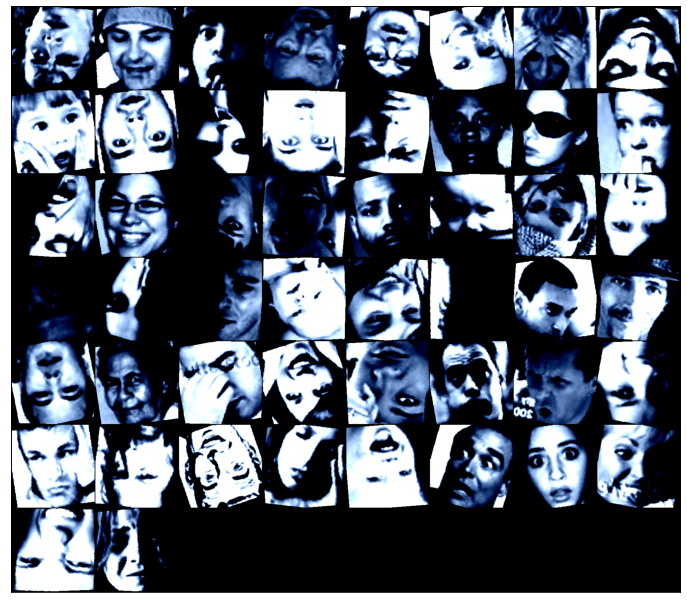

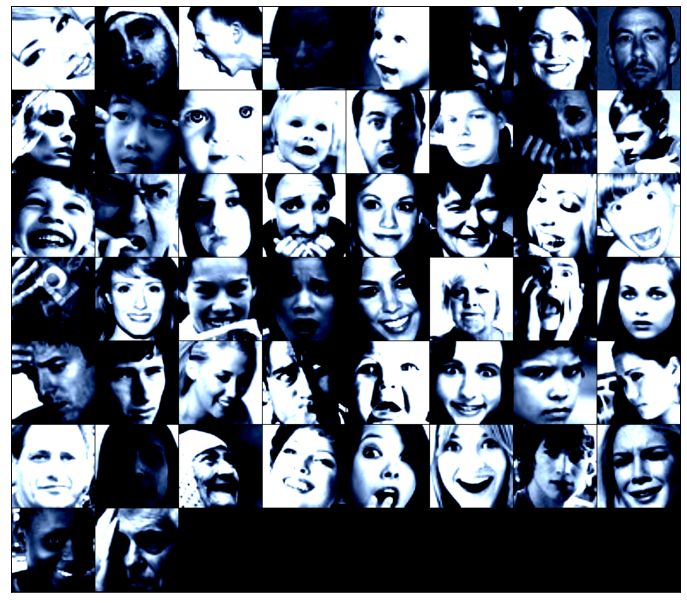

In [6]:
show_batch(train_loader)
show_batch(valid_loader)


<h1> Create ResNet (ResNet50) </h1>

In [8]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print(device)

# download pretrained model
#net = models.resnet50(pretrained = True)

net = models.vgg16_bn(pretrained = True)
#net = densenet = models.densenet161(pretrained = True)
#print(net)
#net = models.efficientnet_b0(pretrained=True)

cuda


In [9]:
#print(torch.cuda.memory_summary())

In [10]:
#print(net)
# define criterion, optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss() 

# import scheduler for learning rate change
from torch.optim.lr_scheduler import ReduceLROnPlateau
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)

# transfer learning -  finetuning the convnet
# unfreeze the base model
#for parameter in net.parameters():
    #parameter.requires_grad = True
                
#num_fcs = net.fc.in_features       
num_fcs = net.classifier[6].in_features
#num_fcs = net.classifier.in_features
                    
#net.fc = nn.Sequential(#nn.Flatten(),
                       #nn.Dropout(0.5),
                       #nn.Linear(num_fcs, 7))

net.classifier[6] = nn.Linear(num_fcs, 7)
#net.classifier = nn.Sequential(#nn.Flatten(),
                               #nn.Dropout(0.5),
                               #nn.Linear(num_fcs, 7),
                              #)

# move the net to gpu
net = net.to(device)

#print(net)

In [11]:
print(net)
#print(torch.cuda.memory_summary())
#learning_rate_decay_start = 80
#learning_rate_decay_every = 5
#learning_rate_decay_rate = 0.9
def train_model(net, epochs, optimizer, criterion):
    epochs = epochs
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    best_accuracy = 0.0
    for epoch in range(epochs):
        net.train()
        running_loss_train = 0.0
        running_loss_val = 0.0
        val_total = 0.0
        train_total = 0.0
        val_correct = 0.0
        train_correct = 0.0
        for inputs, labels in train_loader:
            #inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)   
            loss = criterion(outputs, labels).to(device)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item() * inputs.size(0)
            
            #outputs = torch.exp(outputs)
            outputs = torch.nn.functional.softmax(outputs, dim=1)
            _, train_predicted = torch.max(outputs.data, 1)
            train_total += labels.size()[0]
            train_correct += (train_predicted == labels.data).sum().item()
            #train_correct += torch.sum(train_predicted == labels.data)

        train_losses.append(running_loss_train / len(train_loader.sampler))
        train_accuracy.append(train_correct / train_total)

        with torch.no_grad():
            net.eval()
            for val_data in valid_loader:
                val_inputs, val_labels = val_data
                val_inputs = val_inputs.cuda()
                val_labels = val_labels.cuda()

                prediction = net(val_inputs)
                val_loss = criterion(prediction, val_labels).to(device)
                running_loss_val += val_loss.item() * val_inputs.size(0)

                # compute accuracy
                
                #prediction = torch.exp(prediction)
                prediction = torch.nn.functional.softmax(prediction, dim=1)
                _, predicted = torch.max(prediction.data, 1)
                val_total += val_labels.size()[0]
                val_correct += (predicted == val_labels.data).sum().item()
                #val_correct += torch.sum(predicted == val_labels.data)
            
        val_losses.append(running_loss_val / len(valid_loader.sampler))
        val_accuracy.append(val_correct / val_total)
        
        curr_lr = optimizer.param_groups[0]['lr']
        
        print(f'Epoch {epoch + 1} \t \
            Training Loss: {running_loss_train / len(train_loader.sampler)} \t \
            Validation Loss: {running_loss_val / len(valid_loader.sampler)} \t \
            Training Accuracy: {train_correct / train_total} \t \
            Validation Accuracy: {val_correct / val_total} \t \
            LR: {curr_lr}\n' )
        
        # change learning rate
        exp_lr_scheduler.step()
        
        # save the best model
        if (val_correct / val_total) > best_accuracy:
            torch.save(net, 'C:/Users/jixua/OneDrive/Desktop/Machine learning package/vgg16')
            best_accuracy = val_correct / val_total
    # learning curve
    #fig, ax = plt.subplots()
    #plt.figure(figsize = (10,4))
    fig = plt.figure(figsize = (10,8))
    
    ax1 = fig.add_subplot(221)
    ax1.plot(train_losses, 'r', label = 'train_loss')
    ax1.plot(val_losses, 'g', label = 'val_loss')
    ax1.legend(loc = "upper right")
    ax1.set_title("Learning curve")

    # accuracy curve
    ax2 = fig.add_subplot(223)
    ax2.plot(train_accuracy, 'r', label = 'train_accuracy')
    ax2.plot(val_accuracy, 'g', label = 'val_accuracy')
    ax2.legend(loc = "upper right")
    ax2.set_title("Accuracy curve")
    #plt.show()
    
    # save the model
    #torch.save(net, 'C:/Users/jixua/OneDrive/Desktop/Machine learning package/resnet50')
    
    # save the plot
    fig.savefig("curve_vgg16.pdf")
    return net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Epoch 1 	             Training Loss: 1.3747911150876457 	             Validation Loss: 1.1767843283277035 	             Training Accuracy: 0.4675375571521881 	             Validation Accuracy: 0.5584958217270195 	             LR: 0.01

Epoch 2 	             Training Loss: 1.1362380683486974 	             Validation Loss: 1.069617621745904 	             Training Accuracy: 0.5706074461136512 	             Validation Accuracy: 0.6023676880222841 	             LR: 0.01

Epoch 3 	             Training Loss: 1.0519331150160827 	             Validation Loss: 1.0259736139005606 	             Training Accuracy: 0.6032222947964293 	             Validation Accuracy: 0.621866295264624 	             LR: 0.01

Epoch 4 	             Training Loss: 0.9927802809749116 	             Validation Loss: 1.0009430028020838 	             Training Accuracy: 0.6239494883518397 	             Validation Accuracy: 0.634575208913649 	             LR: 0.01

Epoch 5 	             Training Loss: 0.9498923286331679 	  

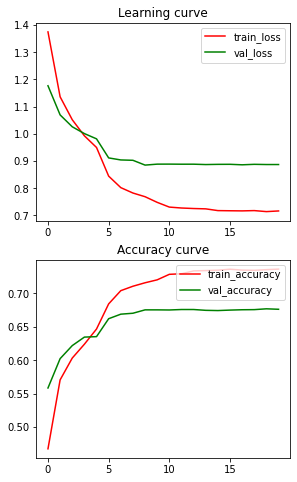

In [12]:
model = train_model(net, 20, optimizer, criterion)

In [13]:
# caclculate accuracy on test loader
def accuracy(model):
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in test_loader:
            model.eval()
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            #outputs = torch.exp(outputs)
            outputs = torch.nn.functional.softmax(outputs, dim=1)
            
            _, outputs = torch.max(outputs.data, 1)
            test_total += labels.size()[0]
            test_correct += (outputs == labels).sum().item()
    print(f'correct: {test_correct}')
    print(f'total: {test_total}')       
    print(f'Accuracy of the network on the {test_total} testing images: {100 * test_correct / test_total} %')

In [14]:
# load model
# vgg16 -> 66.2998 resnet50 -> 66.5645
trained_model = torch.load('vgg16')
#trained_model.eval()
accuracy(trained_model)

correct: 4784
total: 7178
Accuracy of the network on the 7178 testing images: 66.64809139035943 %


In [ ]:
# testing on 主播 寄！maybe transform - special_case_dataloader
image = Image.open('C:/Users/jixua/OneDrive/Desktop/Machine learning package/archive/special_case/happy/honglian2.jpg')
image = transforms.functional.to_tensor(image)
image.unsqueeze_(0)
#print(image.shape)

image = image.to(device)

prediction = trained_model(image)
#prediction = torch.max(prediction.data, 1)[1]
#prediction = torch.exp(prediction)
_, predicted_label = torch.max(torch.nn.functional.softmax(prediction, dim=1),1)
print(labels_class[predicted_label])

#https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

In [ ]:
def visualize(model, num_images = 6):
    # inverse transform
    images_number = 0
    inverse_transform = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225], std = [1/0.229, 1/0.224, 1/0.255])
    fig = plt.figure()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            prediction = model(images)
            
            # uncomment this if using softmax activation
            #prediction = torch.exp(prediction)
            
            prediction = torch.nn.functional.softmax(prediction,dim = 1)
            _, predicted = torch.max(prediction, 1)
            prediction_label = torch.max(prediction).item()
            prediction_label = round(prediction_label, 5)
            
            for i in range(images.size(0)):
                images_number += 1
                ax = plt.subplot(3, 2, images_number)
                ax.axis('off')
                #ax.set_title(f'prediced: {labels_class[predicted[i]]} {prediction_label * 100}%')
                ax.set_title(f'predicted: {labels_class[predicted[i]]}')
                images_inverse = inverse_transform(images)
                plt.imshow(images_inverse.cpu().data[i].permute(1,2,0))
                
                # 0<= images_number <=  num_images, break when it's out range
                if images_number == num_images:
                    return
                

In [ ]:
visualize(trained_model)